### Notebook for the manifold generation of annotated PBMC data (from Yoshida 2022) using `bbknn+scanpy`

COVID-19 airway and matched PBMCs H5AD(raw) downloaded from [here](https://www.covid19cellatlas.org/index.patient.html)

- **Developed by**: Carlos Talavera-López PhD
- **Modified by**: Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation**: 230828
- **Date of modification**: 240215

### Import required modules

In [4]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import seaborn as sns
from pywaffle import Waffle
import matplotlib.pyplot as plt

### Set up working environment

In [5]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
annoy               NA
asttokens           NA
bbknn               1.6.0
colorama            0.4.6
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
executing           2.0.1
h5py                3.10.0
igraph              0.11.4
ipykernel           6.29.2
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.42.0
matplotlib          3.8.2
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.0
numpy               1.26.4
packaging           23.2
pandas              2.2.0
parso               0.8.3
patsy               0.5.6
pickleshare         0.7.5
platformdirs        4.2.0
prompt_toolkit      3.0.42
psutil              5.9.8
pure_eval           0.2.2
pydev_ipyth

### Read in all data 

In [6]:
adata = sc.read_h5ad('/home/guest1/data/ACM_cardiac_leuco/Annotated_PBMC/meyer_nikolic_covid_pbmc_raw.h5ad')

adata

AnnData object with n_obs × n_vars = 422220 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'

In [7]:
adata.raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

adata

AnnData object with n_obs × n_vars = 422220 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'
    layers: 'counts'

### Calculate Highly Variable Genes

In [8]:
adata.obs['sample_id'] = adata.obs['sample_id'].astype('str') 

In [26]:
sc.pp.highly_variable_genes(
    adata,                                      #further analysis is performed on adata again
    flavor = "seurat_v3",
    n_top_genes = 7000,                         #7000 for heterogeneous cell types, 2000 - 4000 for homogeneous cell types like PBMCs
    layer = "counts",                           
    batch_key = "sample_id",                       
    subset = True,
    span = 1
)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


: 

### Calculate graph

In [ ]:
sc.pp.pca(adata, n_comps = 50, use_highly_variable = True, svd_solver = 'arpack', random_state = 1712)
sc.pp.neighbors(adata, use_rep = "X_pca", n_neighbors = 50, metric = 'minkowski', random_state = 1786)
bbknn_sample = bbknn.bbknn(adata, neighbors_within_batch = 4, batch_key = 'sample_id', approx = True, copy = True)

In [ ]:
sc.tl.umap(bbknn_sample, min_dist = 0.3, spread = 4, random_state = 1789)

In [ ]:
sc.pl.umap(bbknn_sample, frameon = False, color = ['nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'nFeature_ADT', 'annotation_detailed_fullNames', 'patient_id', 'sample_id'], size = 1.5, legend_fontsize = 8, ncols = 4, cmap = 'RdPu')              

### Visualise co-variate distribution per sample

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


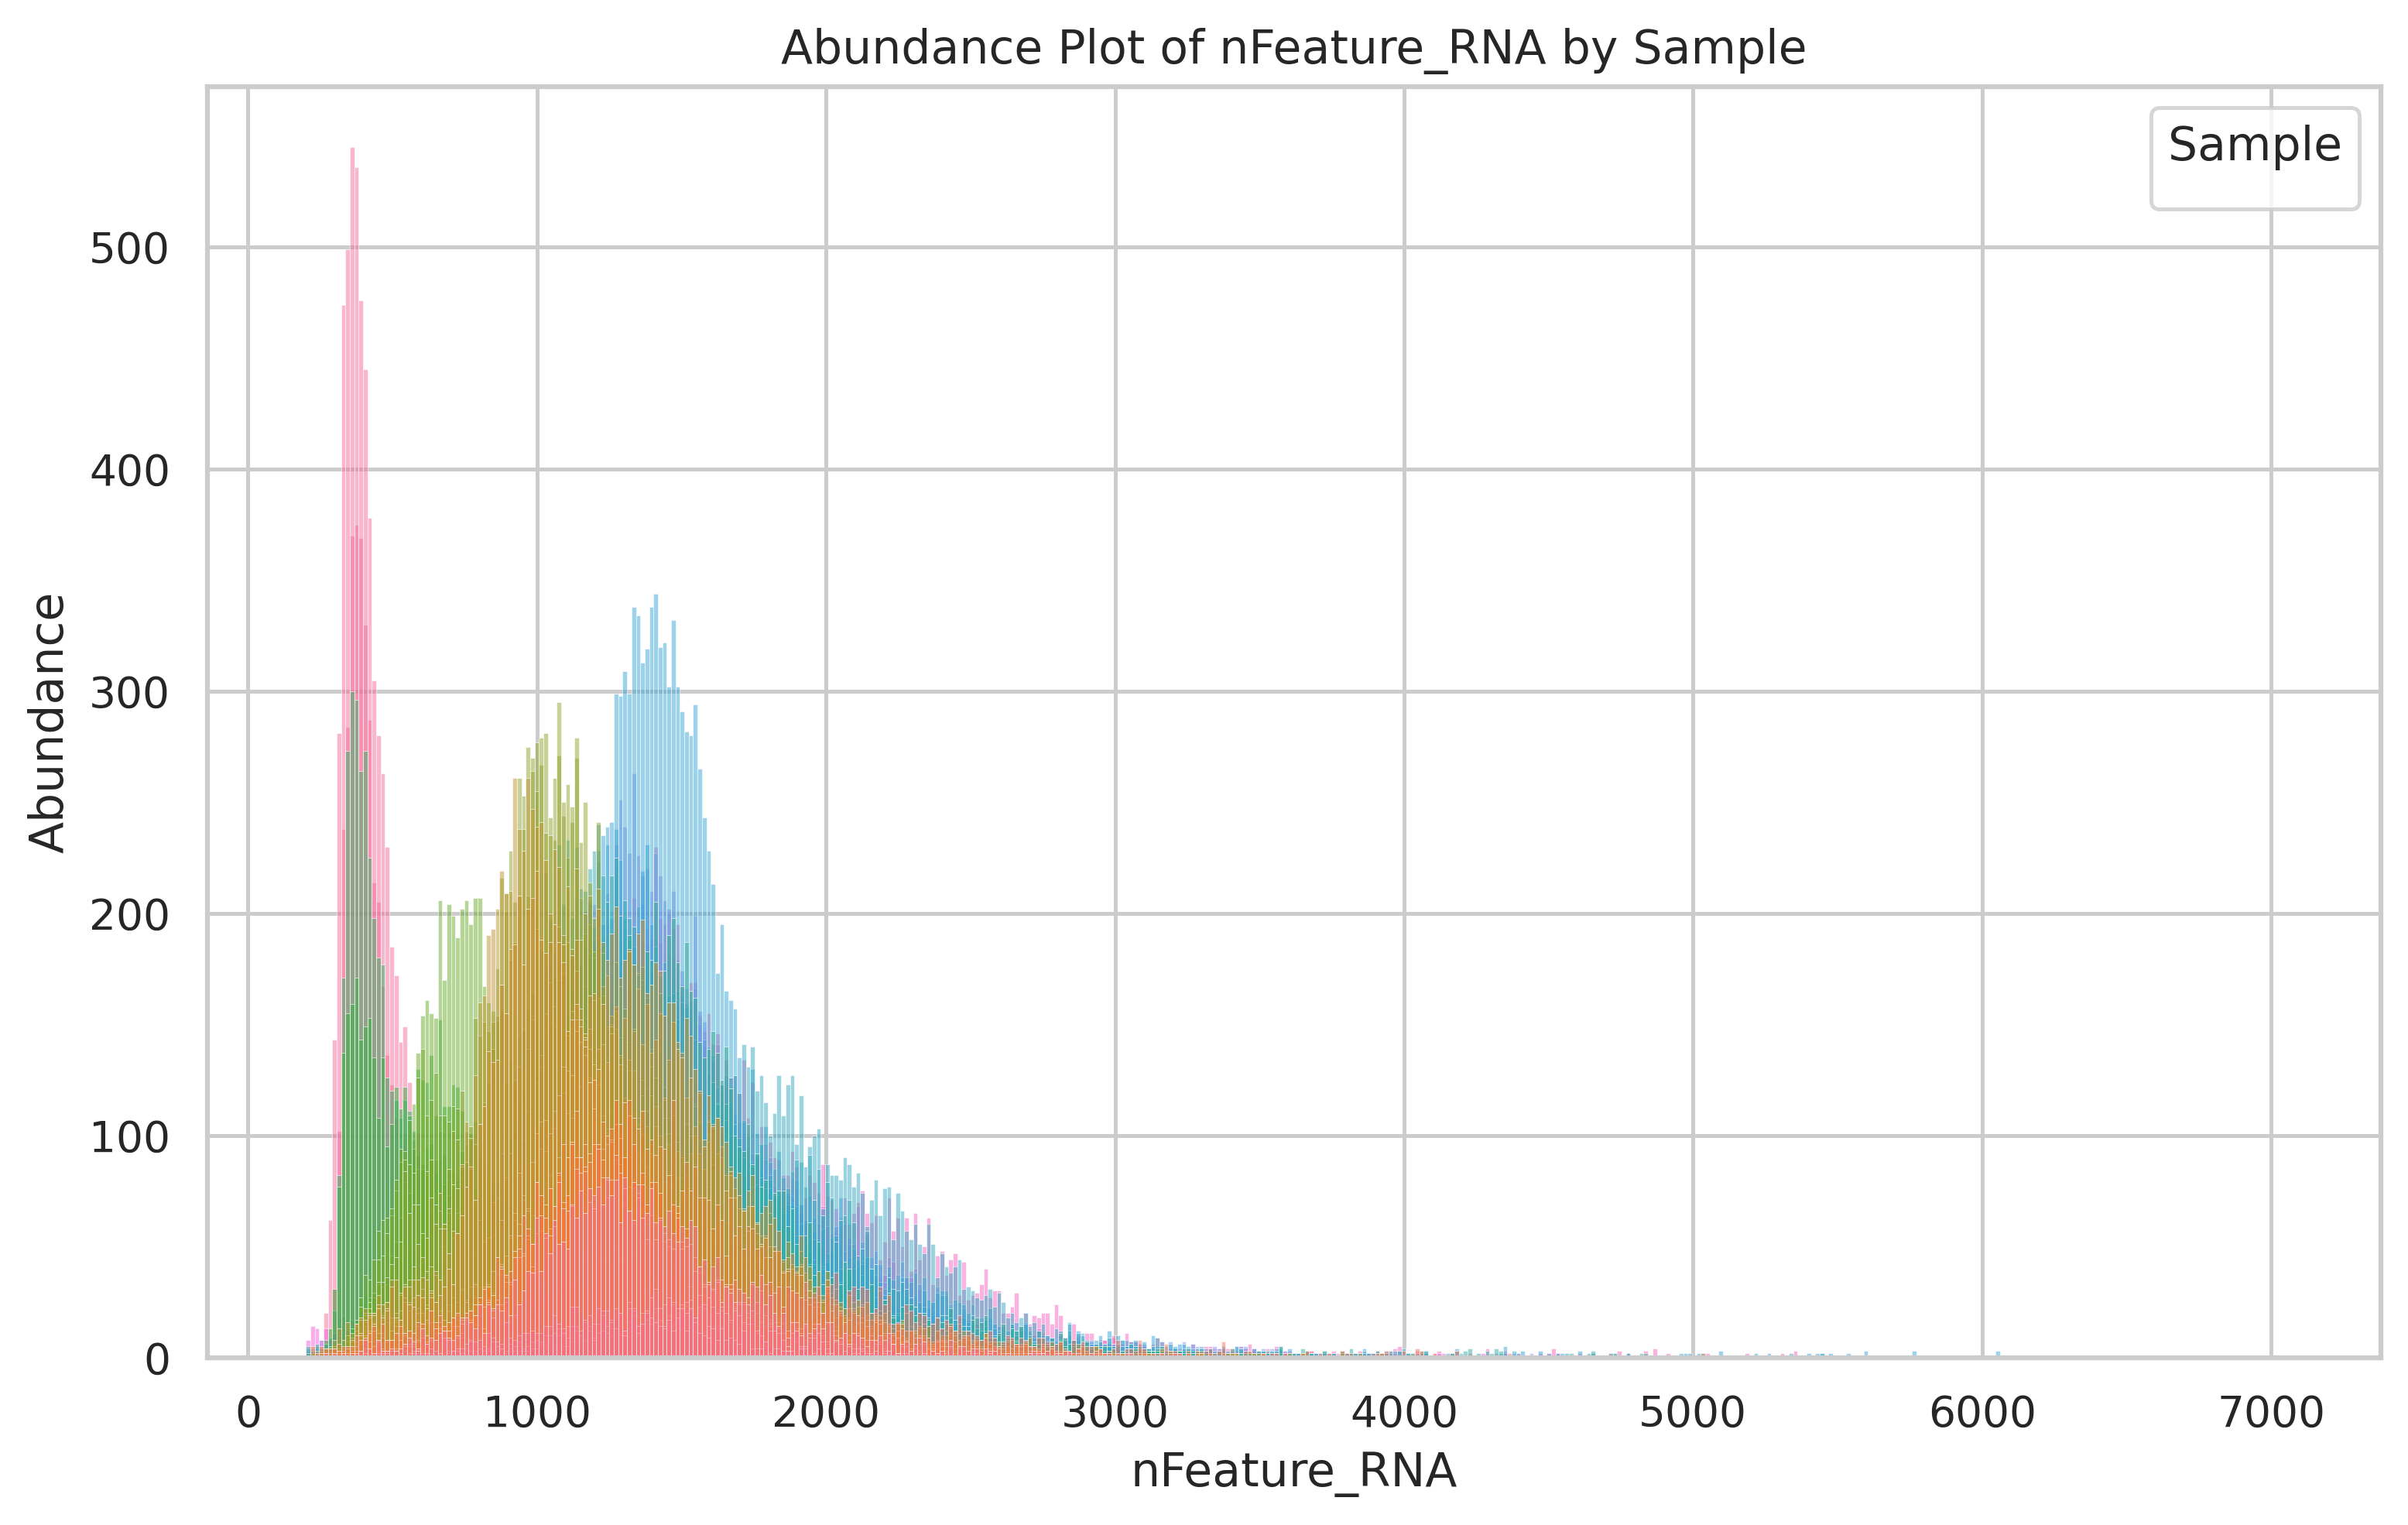

In [9]:
sns.set(style="whitegrid")
covariate_to_visualize = 'nFeature_RNA'

plt.figure(figsize=(10, 6))
sns.histplot(data=adata.obs, x=covariate_to_visualize, hue='sample_id', stat='count', common_norm=False)
plt.xlabel(covariate_to_visualize)
plt.ylabel('Abundance')
plt.title(f'Abundance Plot of {covariate_to_visualize} by Sample')
plt.legend(title='Sample', loc='upper right')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


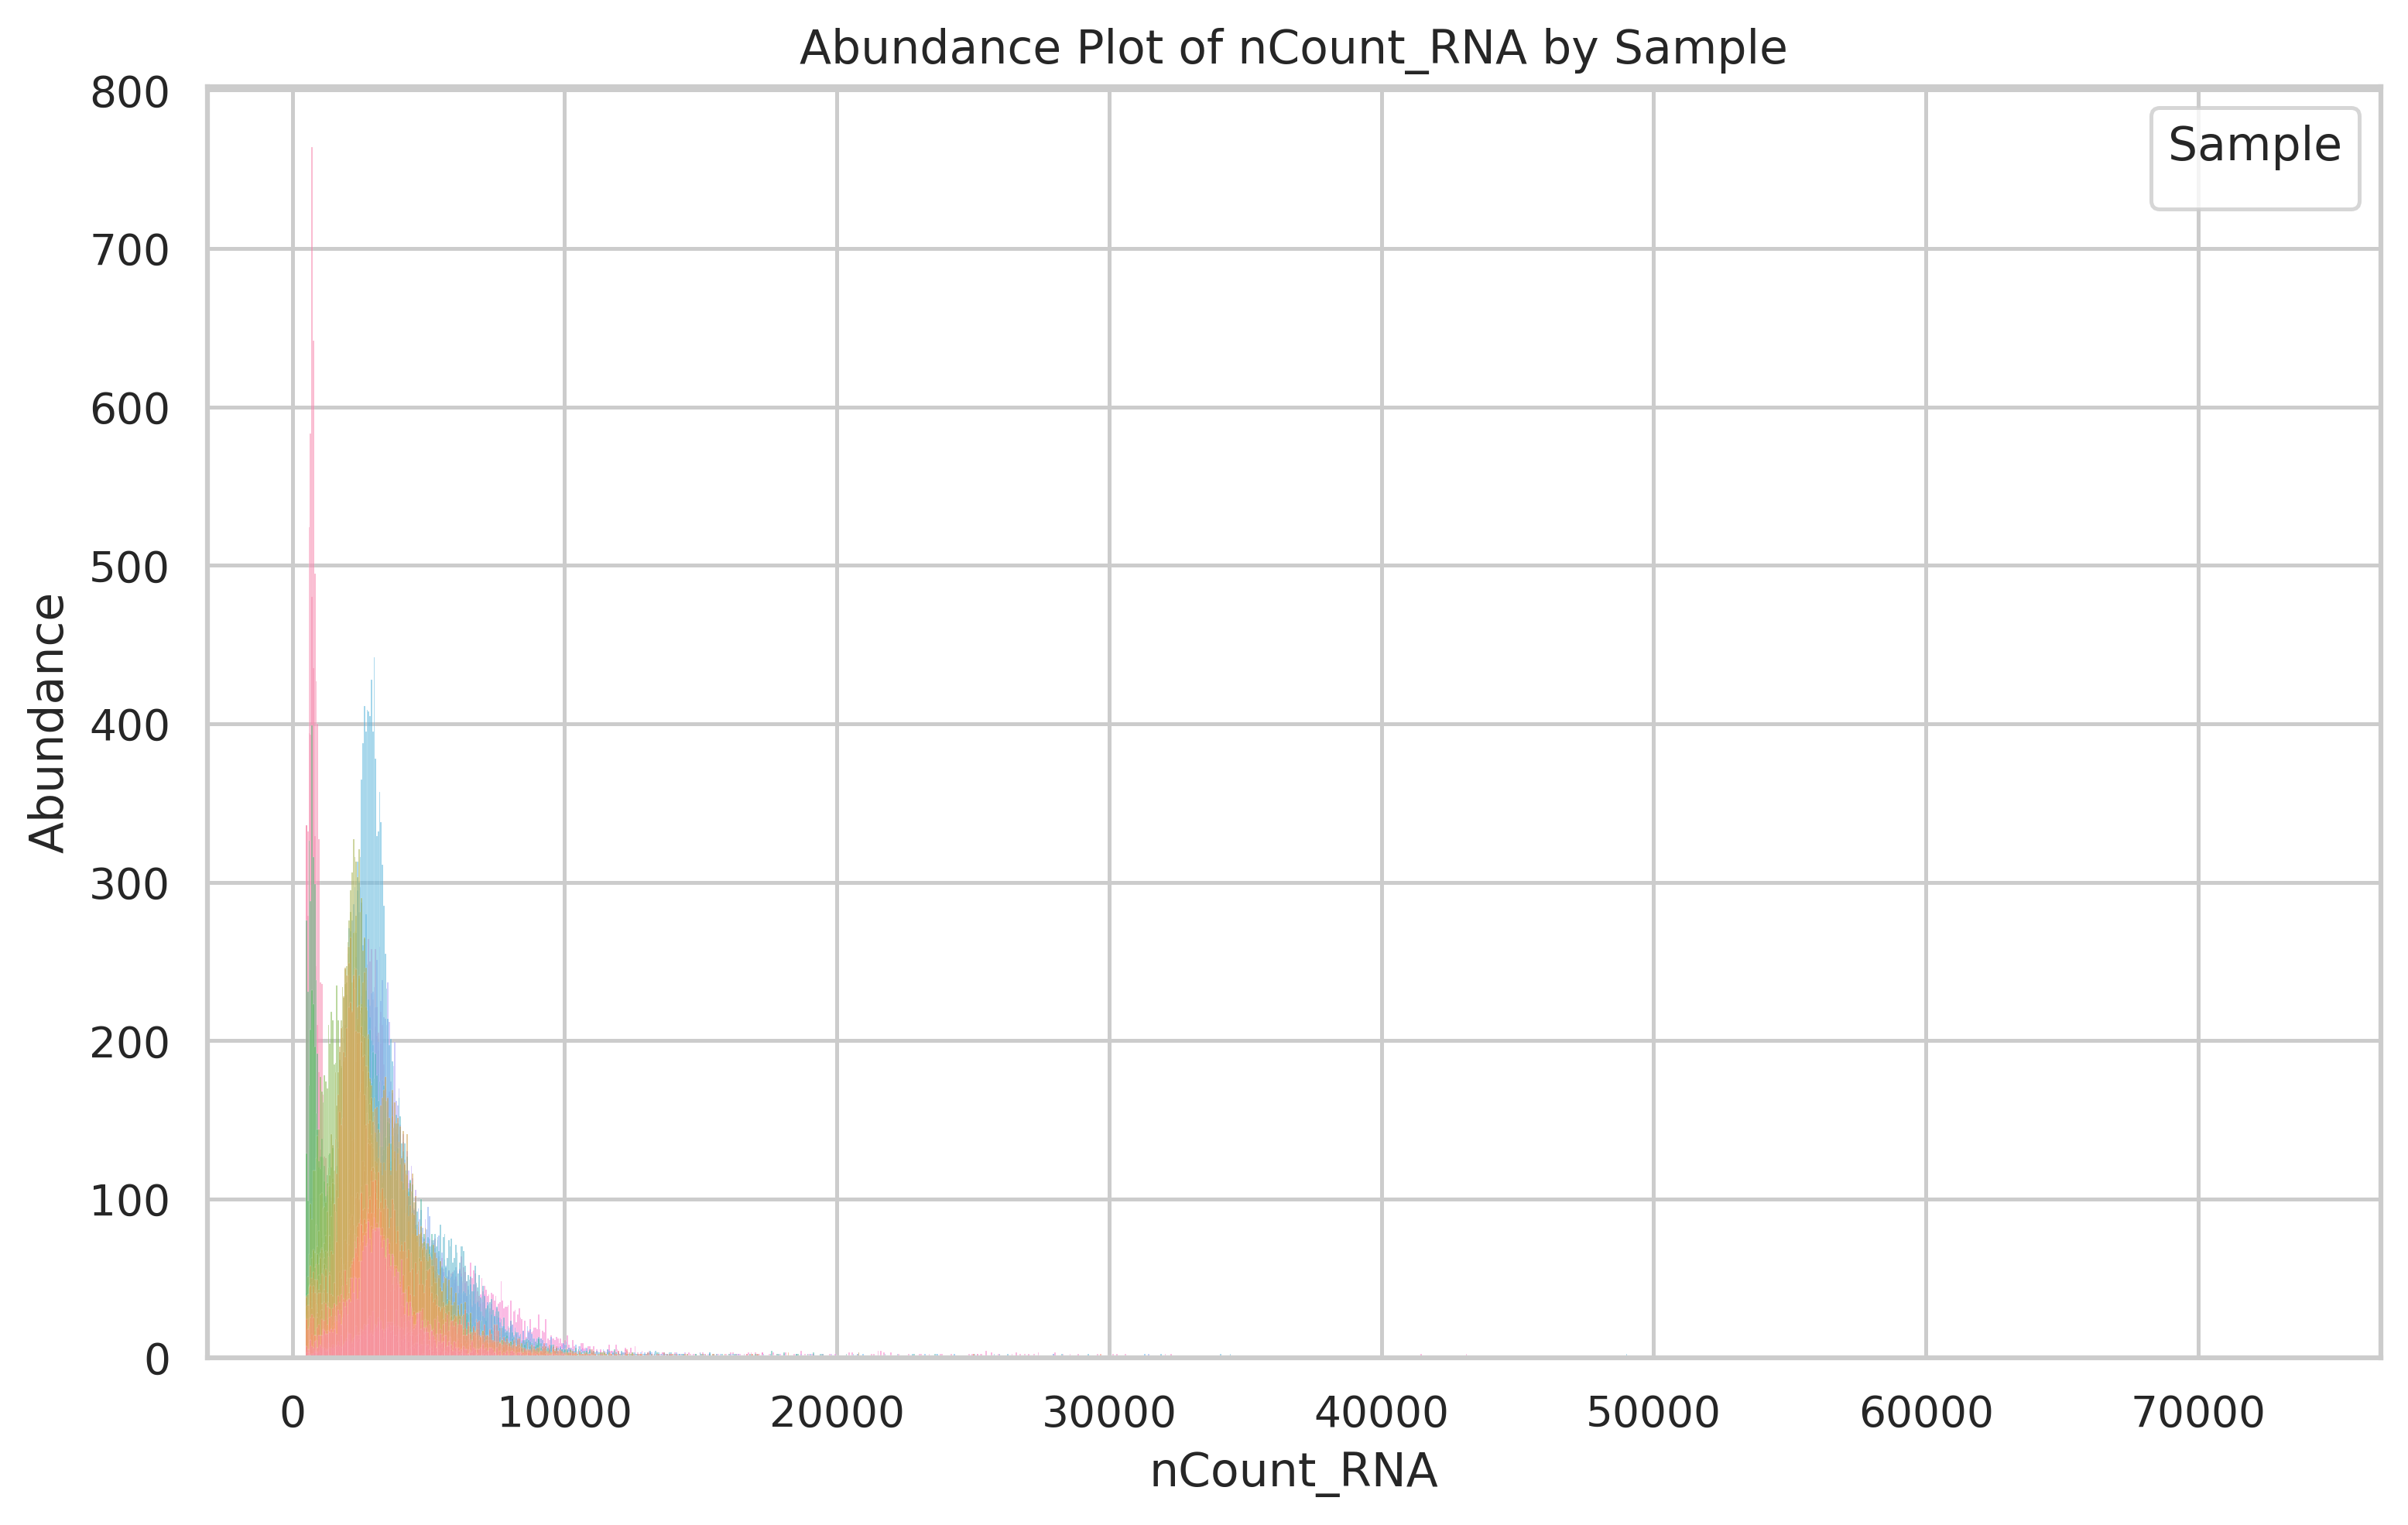

In [10]:
sns.set(style = "whitegrid")
covariate_to_visualize = 'nCount_RNA'

plt.figure(figsize = (10, 6))
sns.histplot(data = adata.obs, x = covariate_to_visualize, hue = 'sample_id', stat = 'count', common_norm = False)
plt.xlabel(covariate_to_visualize)
plt.ylabel('Abundance')
plt.title(f'Abundance Plot of {covariate_to_visualize} by Sample')
plt.legend(title = 'Sample', loc = 'upper right')

plt.show()

In [ ]:
sns.set(style = "whitegrid")
covariate_to_visualize = 'nCount_ADT'

plt.figure(figsize = (10, 6))
sns.histplot(data = adata.obs, x = covariate_to_visualize, hue = 'sample_id', stat = 'count', common_norm = False)
plt.xlabel(covariate_to_visualize)
plt.ylabel('Abundance')
plt.title(f'Abundance Plot of {covariate_to_visualize} by Sample')
plt.legend(title = 'Sample', loc = 'upper right')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


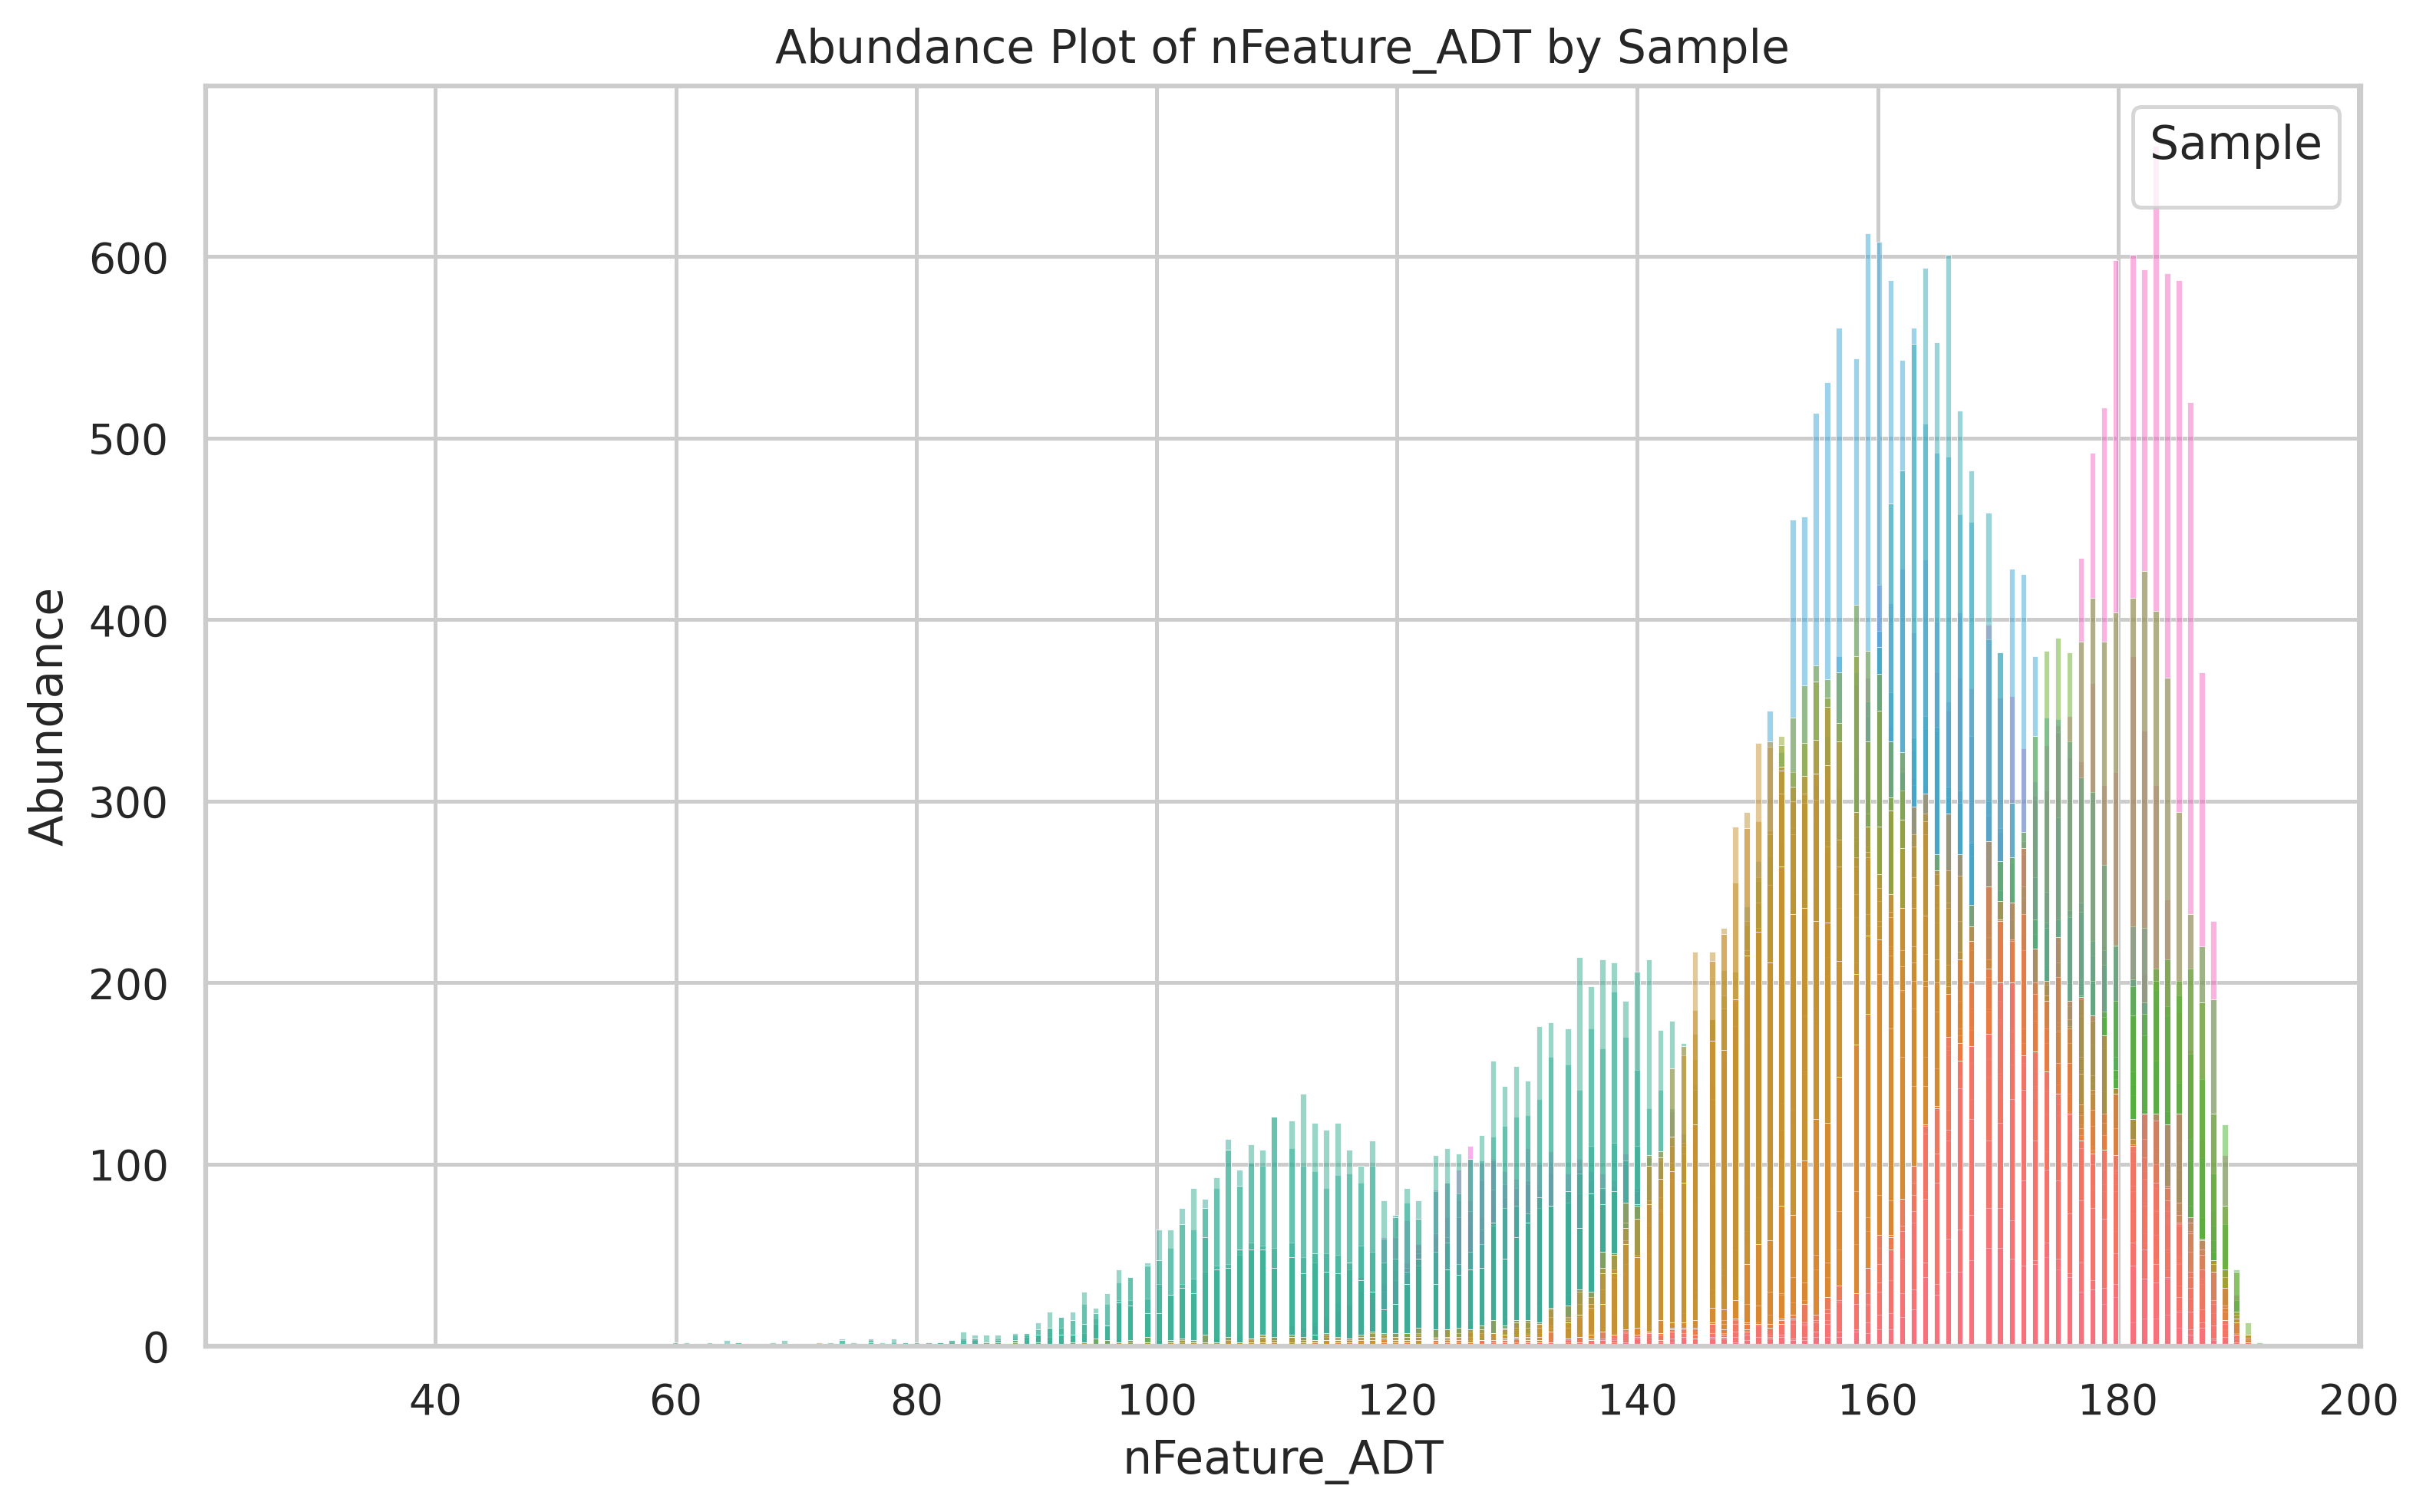

In [11]:
sns.set(style = "whitegrid")
covariate_to_visualize = 'nFeature_ADT'

plt.figure(figsize = (10, 6))
sns.histplot(data = adata.obs, x = covariate_to_visualize, hue = 'sample_id', stat = 'count', common_norm = False)
plt.xlabel(covariate_to_visualize)
plt.ylabel('Abundance')
plt.title(f'Abundance Plot of {covariate_to_visualize} by Sample')
plt.legend(title = 'Sample', loc = 'upper right')

plt.show()

### UMI Count per cell

Shows all barcodes detected in an experiment ranked from highest to lowest UMI count. It should help to identify which GEMs included an intact cell and which GEMs were empty droplets with ambient RNA. Real cells can be found until the changing point.

In [12]:
adata.obs['sample_id']

index
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1    AN5
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1    AN5
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1    AN3
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1    AN5
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1    AN5
                                                       ... 
CV001_KM9294396-CV001_KM9294404_TTTGTCAGTTCTGTTT-1      PC9
CV001_KM9294396-CV001_KM9294404_TTTGTCATCAACCAAC-1      PC9
CV001_KM9294396-CV001_KM9294404_TTTGTCATCATTATCC-1      PC9
CV001_KM9294396-CV001_KM9294404_TTTGTCATCCTATGTT-1      PC9
CV001_KM9294396-CV001_KM9294404_TTTGTCATCTCAAGTG-1      PC2
Name: sample_id, Length: 422220, dtype: object

In [14]:
sample_names = adata.obs['sample_id'].unique()

# Calculate the number of rows and columns for the subplot layout
num_rows = 20
num_cols = 4

# Create a single figure with multiple panels arranged in a grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(80, 300))

# Flatten the axs array to make it easier to iterate
axs = axs.flatten()

# Define a color palette for the lines
color_palette = plt.cm.get_cmap('tab10')

# Loop through each sample and generate the UMI count plot in a separate panel
for idx, sample_name in enumerate(sample_names):
    # Select cells belonging to the current sample
    mask = adata.obs['sample_id'] == sample_name
    sample_adata = adata[mask].copy()

    # Sort cells by UMI counts in descending order
    sample_adata.obs['umi_counts'] = sample_adata.X.sum(axis=1)
    sample_adata = sample_adata[sample_adata.obs['umi_counts'].argsort()[::-1]]

    # Generate the UMI count plot in the current panel
    ax = axs[idx]
    color = color_palette(idx)
    ax.plot(range(1, len(sample_adata) + 1), sample_adata.obs['umi_counts'], marker='o', linestyle='-', label=sample_name, color=color, linewidth=1)
    ax.set_xlabel('Cell Rank')
    ax.set_ylabel('UMI Count')
    ax.set_title(f'UMI Count per Cell for Sample: {sample_name}')
    ax.set_xlim(-10000, 80000)
    ax.set_ylim(0, 1500)  # Set x-axis limit
    ax.legend()

# Adjust layout and save the figure
plt.tight_layout()
output_filename = 'umi_count_subplot.png'
plt.savefig(output_filename)

# Show the figure
plt.show()


/tmp/ipykernel_21909/4002931225.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10')


ValueError: Image size of 24000x90000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 28800x108000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 14400x54000 with 80 Axes>